In [1]:
import py0
import maxent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Initial Guesses

In [2]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.56085644, 0.01232577, 0.42681779],
        [0.32735197, 0.31793285, 0.35471517],
        [0.24506762, 0.50464448, 0.25028791]]),
 array([1., 1., 1.]))

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
C = len(compartments)
tmat = py0.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 0)
tmat.add_transition('A', 'I', 3, 0)
tmat.add_transition('I', 'R', 14, 0)
tmat.value

array([[0.8       , 0.2       , 0.        , 0.        ],
       [0.        , 0.66666667, 0.33333333, 0.        ],
       [0.        , 0.        , 0.92857143, 0.07142857],
       [0.        , 0.        , 0.        , 1.        ]])

In [4]:
start = np.zeros((M, C))
start[0, 1] = 0.1
beta = np.array([0.2, 0.2])
infect = py0.ContactInfectionLayer(beta, [1,2])

## Build Metapopulation Keras Model

In [5]:
model = py0.TrainableMetaModel(start, R, tmat.value, infect, 150, lambda traj: (traj[0, 100, 0, 3] - 0.3)**2)

In [6]:
model.compile(optimizer=tf.keras.optimizers.RMSprop())
utraj = model.get_traj()
model.fit()

100/100 [==============================] - 7s 46ms/step - loss: 0.0218 - output_2_loss: 0.0218


In [7]:
model.summary()

Model: "trainable_meta_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_input_layer (Train multiple                  9         
_________________________________________________________________
trainable_input_layer_1 (Tra multiple                  16        
_________________________________________________________________
trainable_input_layer_2 (Tra multiple                  12        
_________________________________________________________________
metapop_layer (MetapopLayer) multiple                  2         
_________________________________________________________________
traj (AddSusceptibleLayer)   multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 39
Trainable params: 39
Non-trainable params: 0
__________________________________________________

## Plot agreement with constraint

We only set agreement at `T = 100`

In [8]:
traj = model.get_traj()

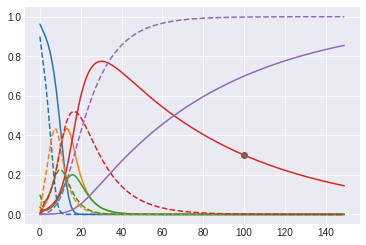

In [9]:
plt.plot(traj[0, :, 0, :])
plt.gca().set_prop_cycle(None)
plt.plot(utraj[0, :, 0, :], linestyle='--')
plt.plot(100, 0.3, 'o')